In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import torch
print(torch.__version__)
print(torch.cuda.device_count())
print(torch.cuda.is_available())
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

1.10.0+cu111
0
False


In [2]:
class NetworkNvidia(nn.Module):
    """NVIDIA model used in the paper."""

    def __init__(self):
        """Initialize NVIDIA model.

        NVIDIA model used
            Image normalization to avoid saturation and make gradients work better.
            Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Drop out (0.5)
            Fully connected: neurons: 100, activation: ELU
            Fully connected: neurons: 50, activation: ELU
            Fully connected: neurons: 10, activation: ELU
            Fully connected: neurons: 1 (output)

        the convolution layers are meant to handle feature engineering
        the fully connected layer for predicting the steering angle.
        """
        super(NetworkNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 2 * 33, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, input):
        """Forward pass."""
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output


# Define model
print("==> Initialize model ...")
model = NetworkNvidia()
print("==> Initialize model done ...")

==> Initialize model ...
==> Initialize model done ...


In [3]:
teslamodel = torch.load("/content/both-nvidia-model-80.h5", map_location=lambda storage, loc: storage)
start_epoch = teslamodel['epoch']
model.load_state_dict(teslamodel['state_dict'])

<All keys matched successfully>

In [4]:
model.eval()

NetworkNvidia(
  (conv_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=4224, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [5]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())[0]
model_children

Sequential(
  (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (1): ELU(alpha=1.0)
  (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (3): ELU(alpha=1.0)
  (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (5): ELU(alpha=1.0)
  (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ELU(alpha=1.0)
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): Dropout(p=0.5, inplace=False)
)

In [6]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 5


In [7]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2)) ====> SHAPE: torch.Size([24, 3, 5, 5])
CONV: Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2)) ====> SHAPE: torch.Size([36, 24, 5, 5])
CONV: Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2)) ====> SHAPE: torch.Size([48, 36, 5, 5])
CONV: Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 48, 3, 3])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([64, 64, 3, 3])


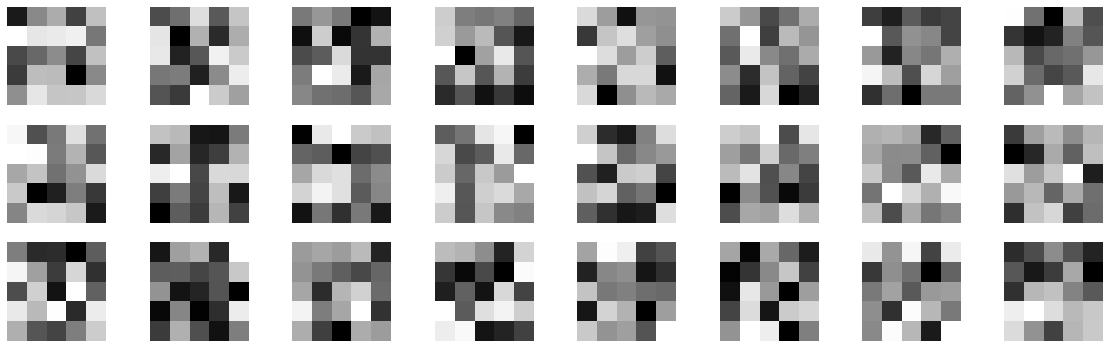

In [8]:
import matplotlib.pyplot as plt

# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) 
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./outputs/filter.png')
plt.show()

In [9]:
!pip install cv

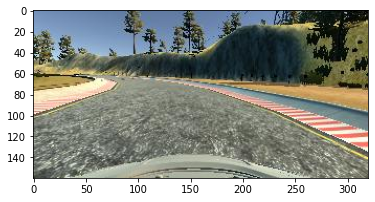

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


In [11]:
import cv2
# read and visualize an image
img = cv2.imread("/content/input/center_2019_04_02_19_25_33_671.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [12]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([24, 254, 254])
Saving layer 0 feature maps...


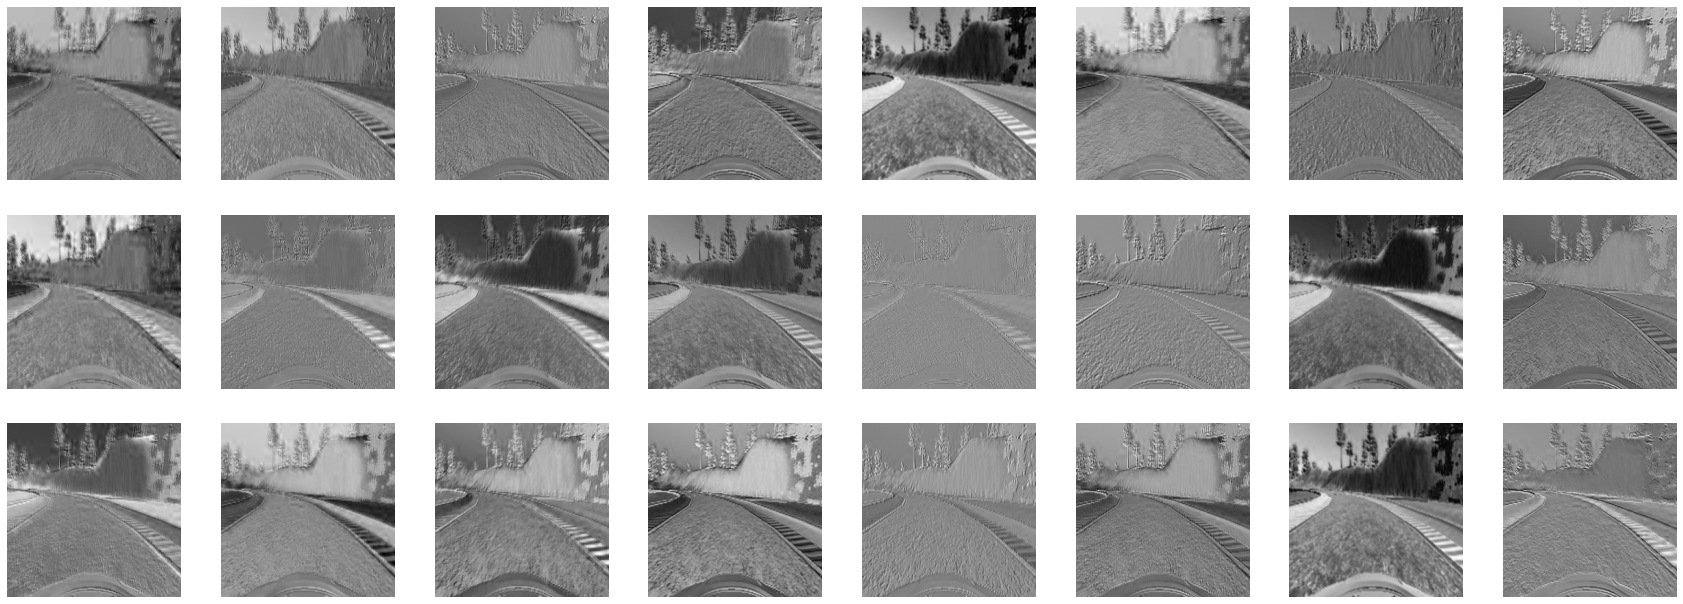

torch.Size([36, 125, 125])
Saving layer 1 feature maps...


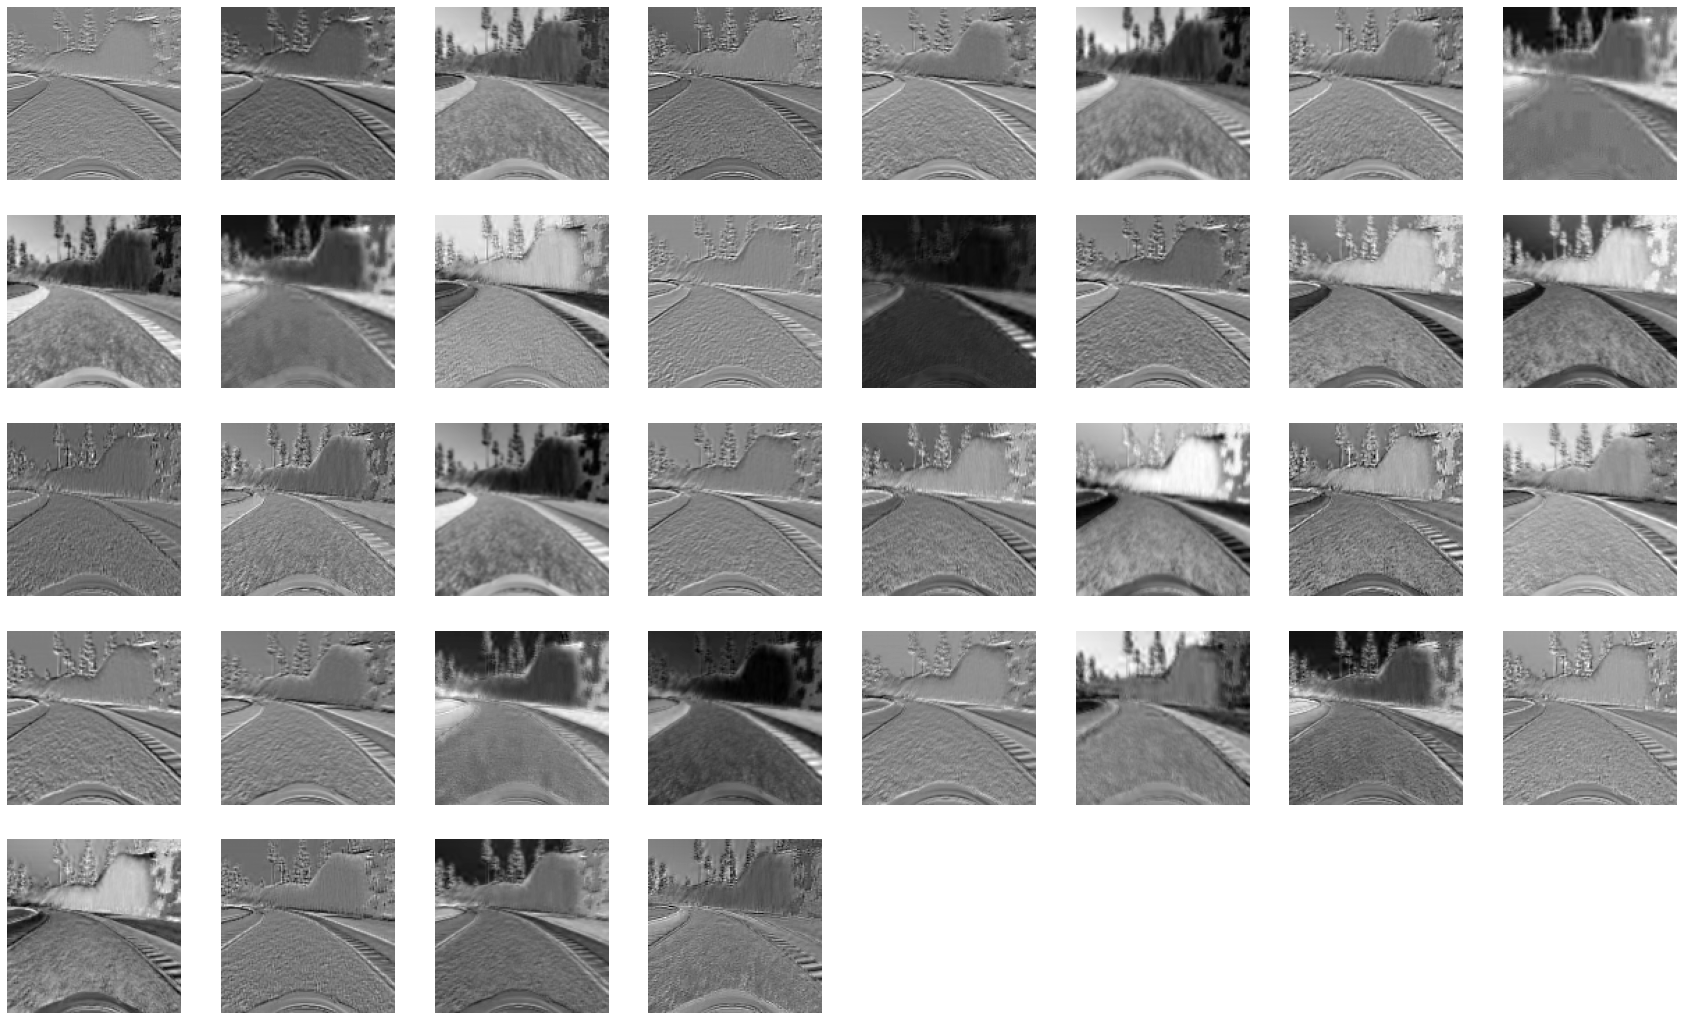

torch.Size([48, 61, 61])
Saving layer 2 feature maps...


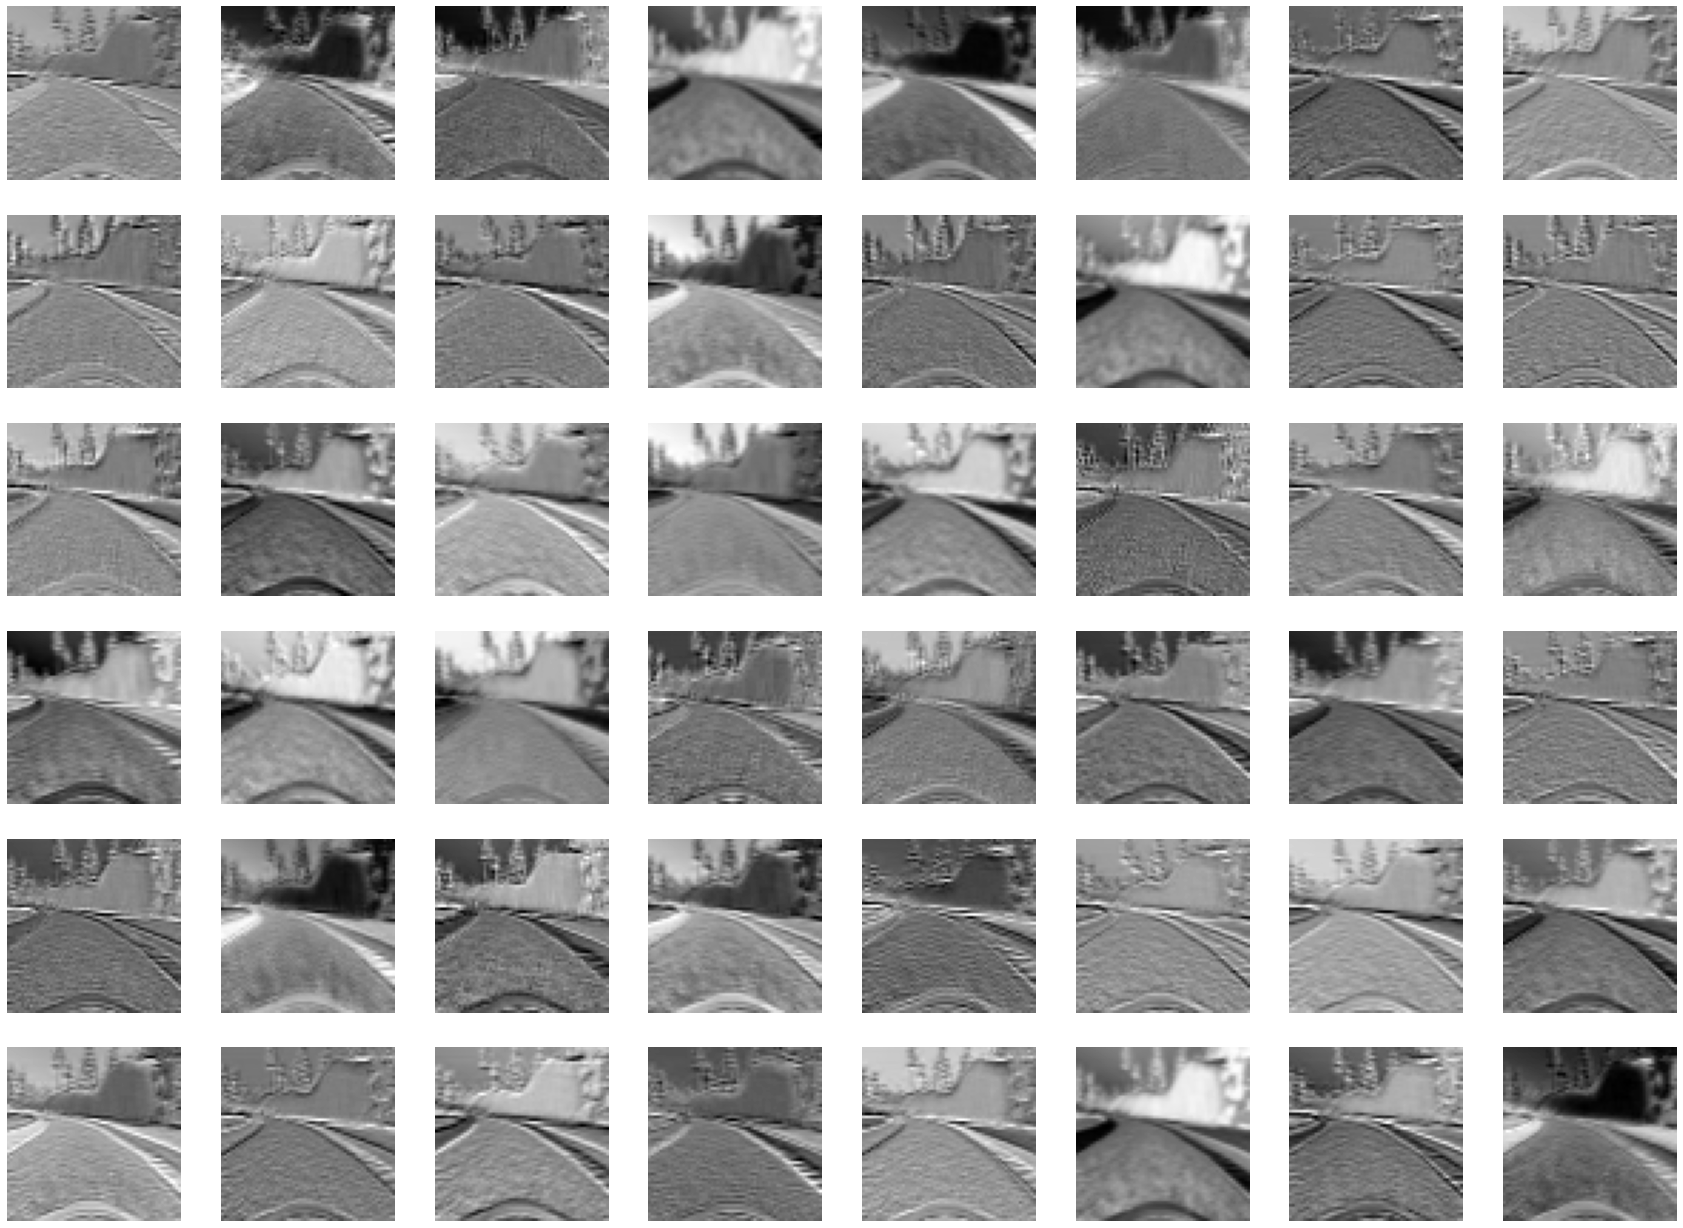

torch.Size([64, 59, 59])
Saving layer 3 feature maps...


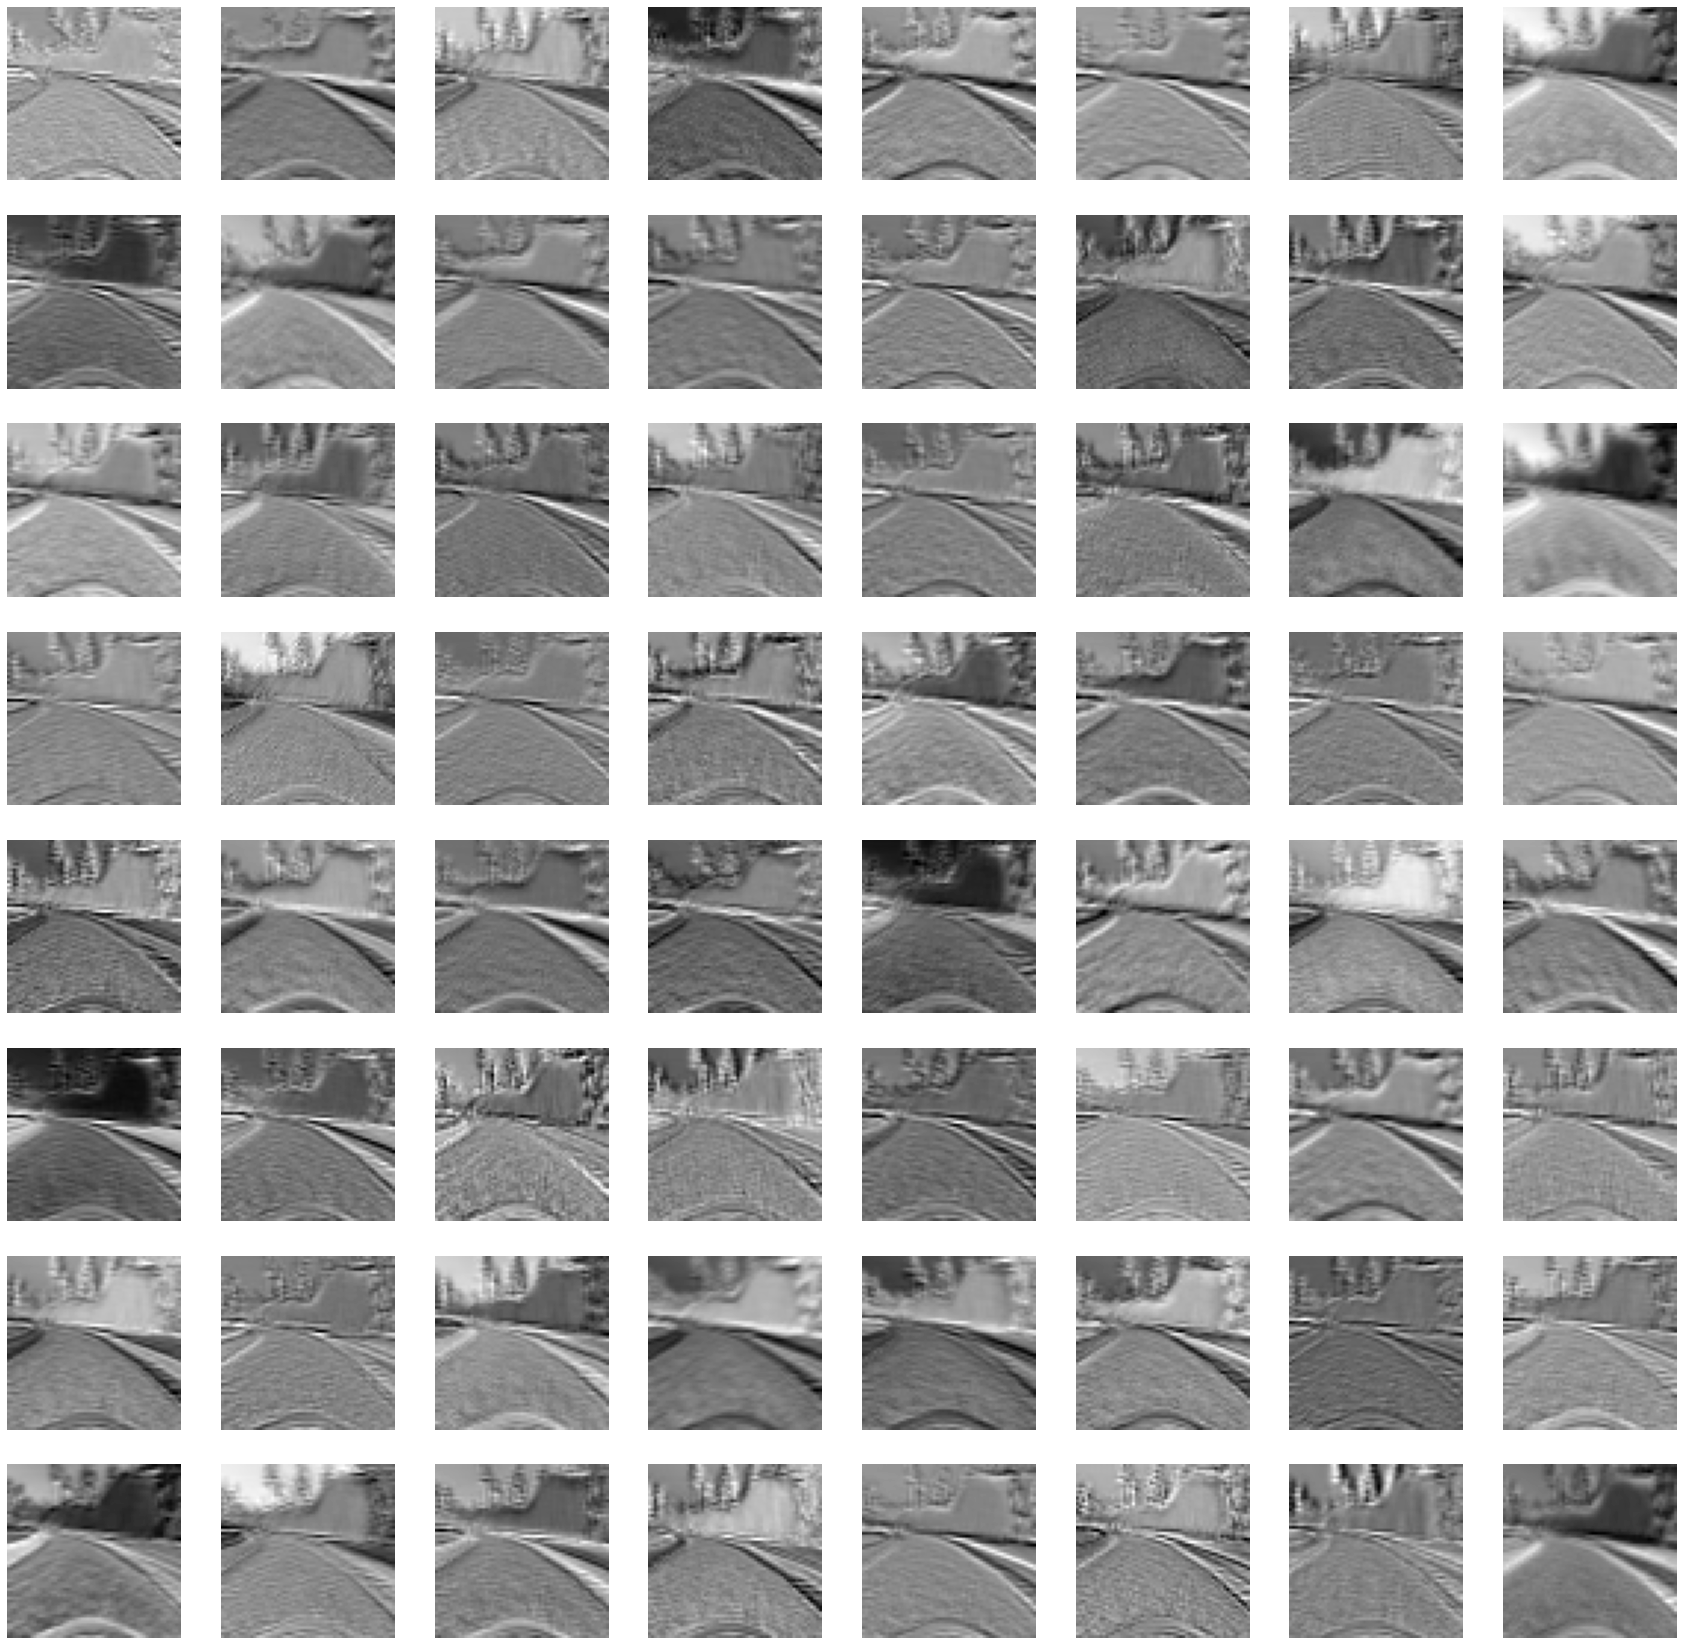

torch.Size([64, 57, 57])
Saving layer 4 feature maps...


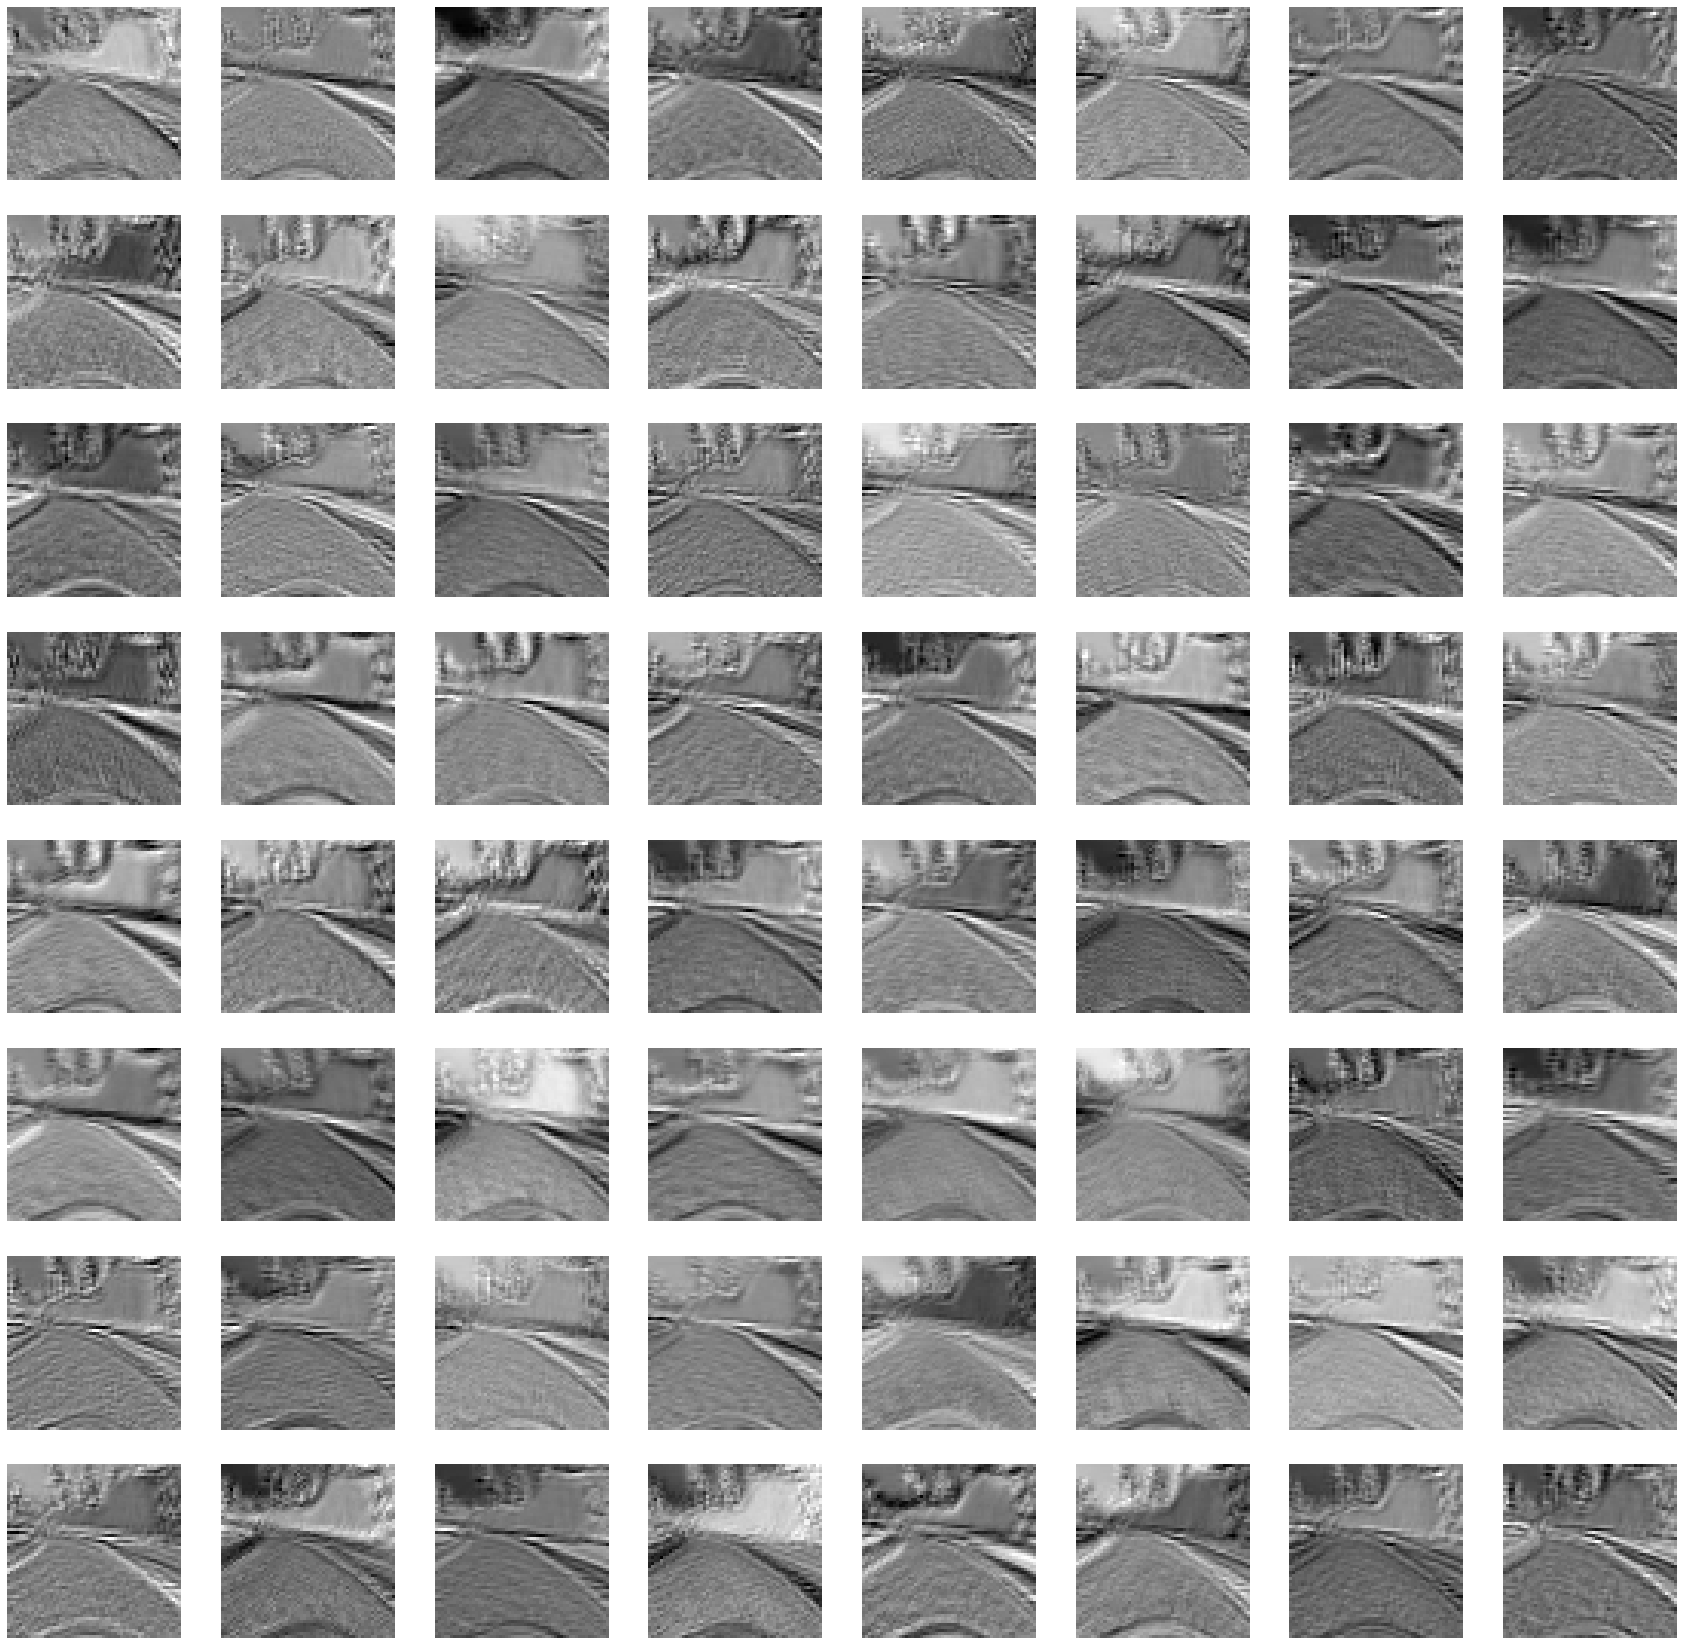

In [13]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()